In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as pt
import warnings


warnings.filterwarnings('ignore')
plt.style.use('dark_background')
np.set_printoptions(suppress=True)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import dendrogram,linkage,cophenet


In [2]:
data = pd.read_excel('/kaggle/input/power1/power.xlsx')
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,2.242,0.162,237.33,10.0,1,7,17
1,3.714,0.296,235.15,15.8,2,35,17
2,3.212,0.304,235.99,14.2,1,26,17
3,3.694,0.280,235.16,15.6,1,35,17
4,3.204,0.292,236.08,14.0,1,27,17


# Let'take some insights of the data

In [3]:
data.shape

(21240, 7)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21240 entries, 0 to 21239
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Global_active_power           21240 non-null  float64
 1   Global_reactive_power         21240 non-null  float64
 2   Voltage                       21240 non-null  float64
 3   Global_intensity              21240 non-null  float64
 4   Kitchen_consumption           21240 non-null  int64  
 5   Laundry_consumption           21240 non-null  int64  
 6   Other_appliances_consumption  21240 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.1 MB


## Insight
* so there's no missing values in the data
* all columns are numerical so no need to encode

In [26]:
summary_df = pd.DataFrame(data.dtypes,columns=['Data Type'])
summary_df['missing values'] = data.isna().sum()
summary_df['uniques'] = data.nunique().values
summary_df['count'] = data.count().values
summary_df['max'] = data.max().values
summary_df['min'] = data.min().values

In [31]:
summary_df.style.background_gradient(cmap='rainbow')

,Data Type,missing values,uniques,count,max,min
Global_active_power,float64,0,3501,21240,9.994000,0.302000
Global_reactive_power,float64,0,420,21240,1.198000,0.046000
Voltage,float64,0,1861,21240,249.150000,225.120000
Global_intensity,float64,0,198,21240,43.400000,1.200000
Kitchen_consumption,int64,0,40,21240,40.000000,1.000000
Laundry_consumption,int64,0,59,21240,60.000000,1.000000
Other_appliances_consumption,int64,0,30,21240,30.000000,1.000000


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,21240.0,3.290522,1.625414,0.302,1.866,3.184,4.246,9.994
Global_reactive_power,21240.0,0.259400,0.144701,0.046,0.148,0.236,0.342,1.198
Voltage,21240.0,237.324997,3.416039,225.120,235.180,237.500,239.570,249.150
Global_intensity,21240.0,14.020800,6.969000,1.200,8.000,13.600,18.000,43.400
Kitchen_consumption,21240.0,13.424529,16.472617,1.000,1.000,2.000,36.000,40.000
Laundry_consumption,21240.0,9.266667,13.661116,1.000,1.000,2.000,15.000,60.000
Other_appliances_consumption,21240.0,16.654379,4.156162,1.000,17.000,17.000,18.000,30.000


## Bivariate Analysis :- 

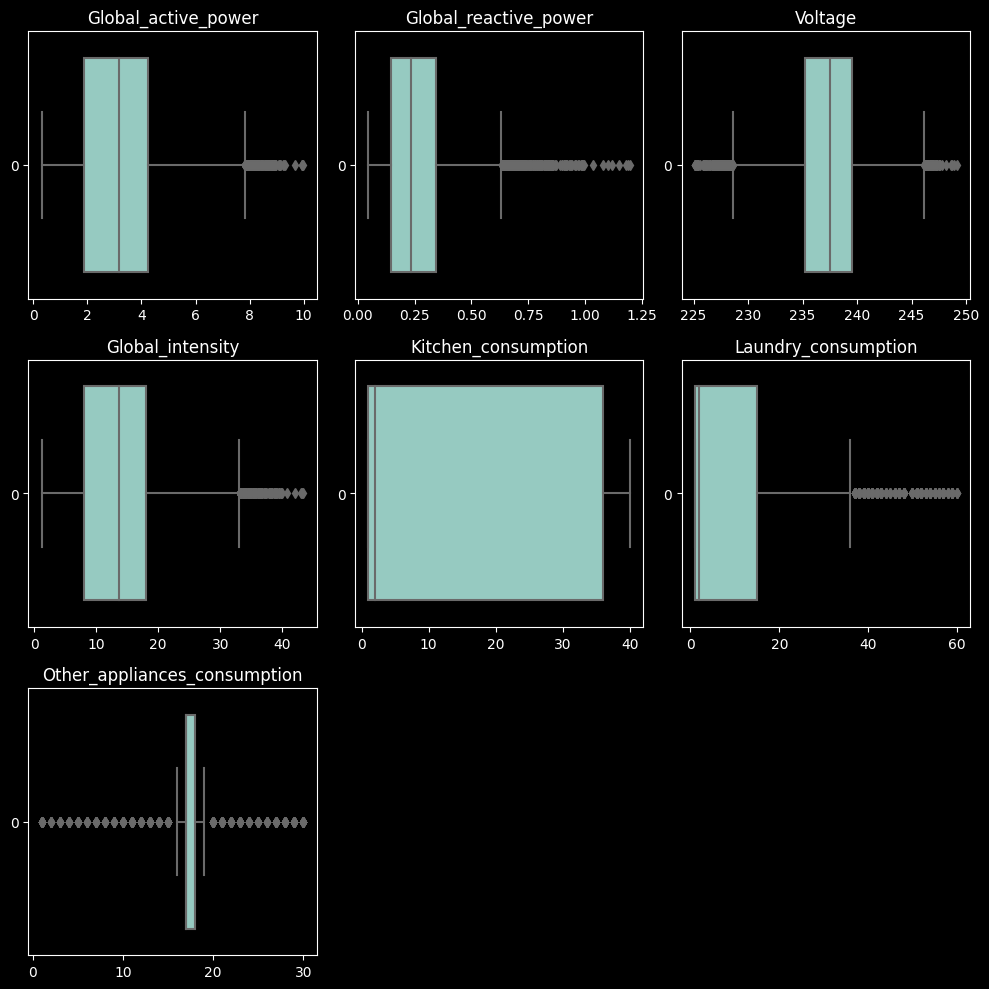

In [59]:
t=1
plt.figure(figsize=(10,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot( data[i],orient='h')
    plt.title(i)
    t+=1
plt.tight_layout()
plt.show()

## **there's no extreme outliers in the data**

### Lets reduce the dimension of the data for better visualisation and clustering

In [36]:
sc = StandardScaler()
df_s = sc.fit_transform(data)
df_s = pd.DataFrame(df_s, columns= data.columns)
df_s

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,-0.645095,-0.673126,0.001465,-0.576969,-0.754271,-0.165925,0.083161
1,0.260541,0.252945,-0.636716,0.255308,-0.693563,1.883736,0.083161
2,-0.048310,0.308233,-0.390812,0.025714,-0.754271,1.224917,0.083161
3,0.248236,0.142369,-0.633789,0.226609,-0.754271,1.883736,0.083161
4,-0.053232,0.225301,-0.364465,-0.002985,-0.754271,1.298119,0.083161
...,...,...,...,...,...,...,...
21235,-0.294407,0.211479,0.504984,-0.318676,-0.693563,-0.531936,0.083161
21236,-0.327630,0.211479,0.376177,-0.347375,-0.754271,-0.605138,0.323773
21237,-0.332552,0.183835,0.218095,-0.347375,-0.693563,-0.605138,0.083161
21238,-0.229192,0.059438,-0.065866,-0.232578,-0.754271,-0.605138,0.323773


In [37]:
# let's apply PCA
pca = PCA(n_components= 7)

In [38]:
pca.fit(df_s)

PCA(n_components=7)

In [39]:
# eigen values
pca.explained_variance_

array([3.1531922 , 1.14222068, 0.97792442, 0.90655462, 0.65237637,
       0.16738138, 0.00067991])

In [40]:
# measure of how much of the total variance in the original dataset is explained by each principal component.
pca.explained_variance_ratio_

array([0.45043482, 0.1631667 , 0.13969691, 0.12950171, 0.09319224,
       0.0239105 , 0.00009713])

In [42]:
# cummulative sum
np.cumsum(pca.explained_variance_ratio_)

array([0.45043482, 0.61360152, 0.75329843, 0.88280014, 0.97599237,
       0.99990287, 1.        ])

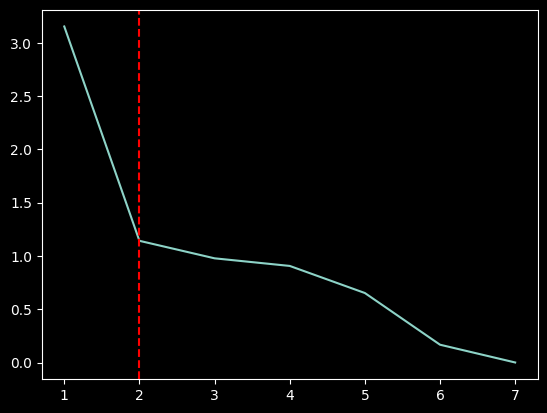

In [44]:
# scree plot- plot to  find the n_components of clustering 
# so the elbow point is our number of PCA has to be

plt.plot(pca.explained_variance_ )
plt.xticks( range(0,7) , range(1,8))
plt.axvline( x=1, color ='r', ls ='--')
plt.show()

In [45]:
pca.explained_variance_

array([3.1531922 , 1.14222068, 0.97792442, 0.90655462, 0.65237637,
       0.16738138, 0.00067991])

In [46]:
# Kesiar criterion
# The Kaiser criterion is a rule in factor analysis that states that you should only keep the factors that have eigenvalues greater than one.
# This means that you are only retaining the factors that explain more variance than a single variable would on its own

pca.explained_variance_[pca.explained_variance_>=1]
# so in Kesiar criterian again we're getting 2

array([3.1531922 , 1.14222068])

In [48]:
# so lets go with 2 PCA components
pca = PCA(n_components=2)

In [49]:
data_pca = pd.DataFrame(pca.fit_transform(df_s) , columns=['PC1','PC2'])
data_pca

,PC1,PC2
0,-1.067477,-0.532983
1,0.922166,-1.236260
2,0.295110,-0.864841
3,0.866390,-1.313918
4,0.284213,-0.939421
...,...,...
21235,-0.946356,0.038911
21236,-0.995878,-0.071815
21237,-0.902515,0.075620
21238,-0.727290,-0.150238


In [58]:
plt.figure(figsize=(10,8))
fig=pt.scatter(data_frame=data_pca,x = 'PC1',y = 'PC2')
fig.show()

<Figure size 1000x800 with 0 Axes>

### Lets do k-means clustering

In [23]:
# Elblow plot to identify the no of clusters

In [80]:
wcss=[]
for i in range(2,10):
    model = KMeans(n_clusters=i)
    model.fit(data_pca)
    wcss.append(model.inertia_)

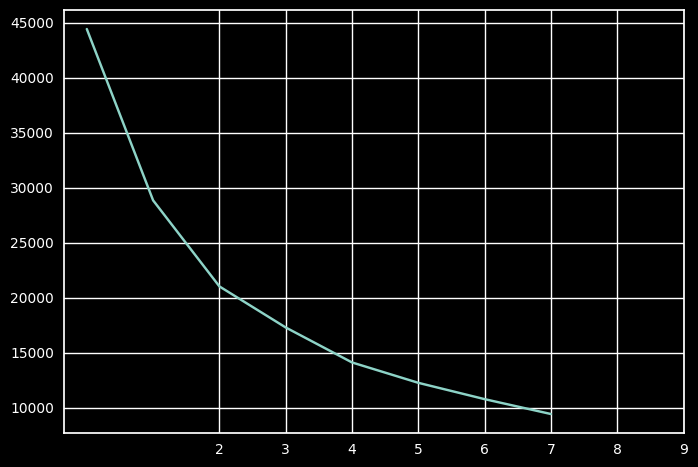

In [86]:
# we're using both methods but wcss(elbowplot) and kelbowplotvisualier is one of the same thing
plt.plot(wcss)
plt.xticks(range(2,10),range(2,10))
plt.show()

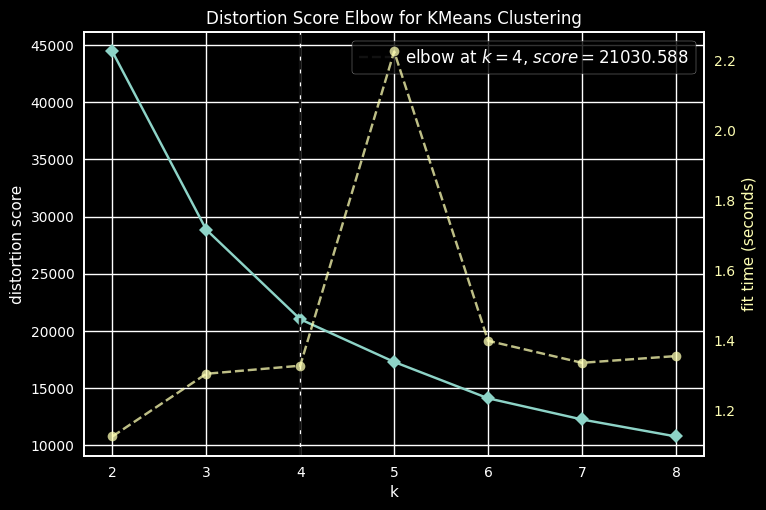

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [65]:
k_elblow = KElbowVisualizer(z=KMeans(),k=8  )
k_elblow.fit(data_pca)
k_elblow.show()

In [87]:
# one more different method to find the best n_clusers :- silhoutte visualiser

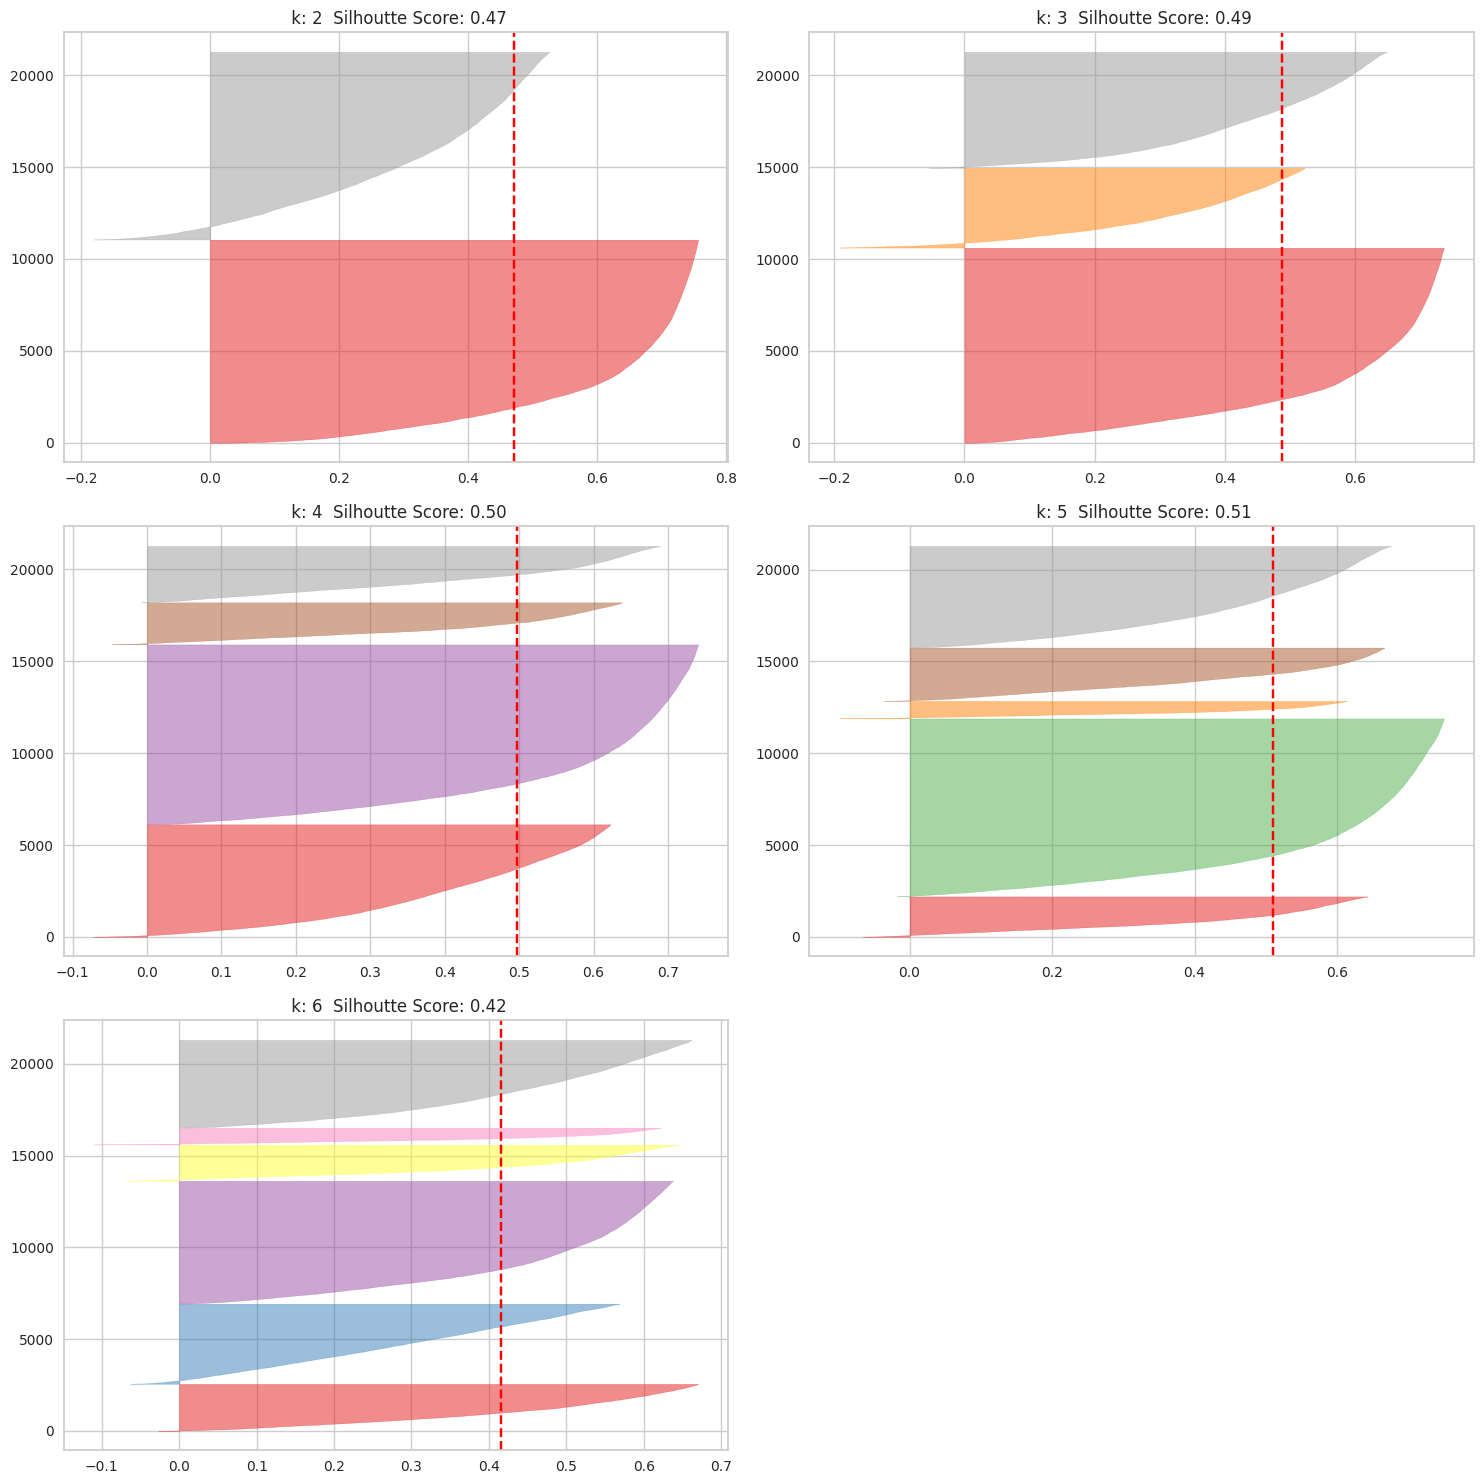

In [27]:
t =1
plt.figure(figsize= (15,15))
for i in range(2,7):
    plt.subplot( 3,2,t)
    model = KMeans(n_clusters=i)
    sil_viz = SilhouetteVisualizer(model )
    sil_viz.fit(data_pca)
    plt.title(' k: %d  Silhoutte Score: %.2f' %(i,sil_viz.silhouette_score_ ))
    t+=1
plt.tight_layout()
plt.show()
    

In [28]:
# Lets go with k = 4

In [102]:
model_kmean = KMeans( n_clusters=4 )
y_pred_kmeans = model_kmean.fit_predict(data_pca)
y_pred_kmeans

array([0, 3, 3, ..., 0, 0, 0], dtype=int32)

In [103]:
centroid = model_kmean.cluster_centers_
centroid

array([[-1.57322334, -0.11210145],
       [ 3.3603993 , -0.6346796 ],
       [ 0.91379133,  1.08088251],
       [ 0.71731198, -1.3335723 ]])

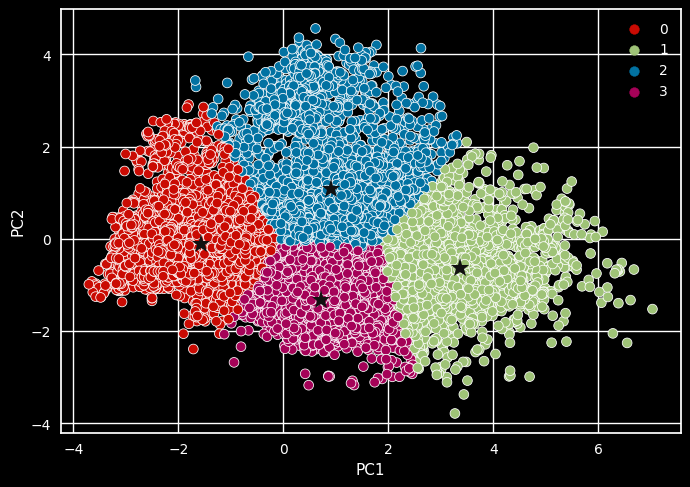

In [104]:
sns.scatterplot( x = data_pca['PC1'] , y=data_pca['PC2'] , hue= y_pred_kmeans, palette=['r','g','b','m'] )

for i in range(4):
    plt.plot( centroid[i][0], centroid[i][1], marker ='*' , ms =14, color='k')
plt.show()

## Inferences

In [105]:
data['Kmeans_label'] = y_pred_kmeans
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Overall_avg_consumption,Kmeans_label
0,2.242,0.162,237.33,10.0,1,7,17,8.333333,0
1,3.714,0.296,235.15,15.8,2,35,17,18.000000,3
2,3.212,0.304,235.99,14.2,1,26,17,14.666667,3
3,3.694,0.280,235.16,15.6,1,35,17,17.666667,3
4,3.204,0.292,236.08,14.0,1,27,17,15.000000,3


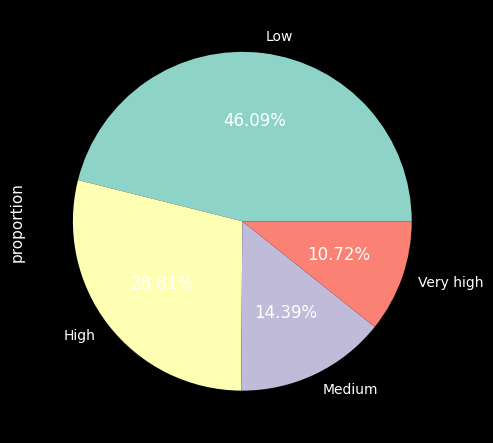

In [194]:
data['Kmeans_label'].value_counts(normalize=True).plot(kind='pie',autopct= '%.2f%%')
plt.show()

In [107]:
data.groupby(by='Kmeans_label').mean().T

Kmeans_label,0,1,2,3
Global_active_power,1.921663,6.350640,3.982738,4.010179
Global_reactive_power,0.242496,0.277663,0.304051,0.210537
Voltage,239.066024,233.437021,236.276455,236.743236
Global_intensity,8.147962,27.277592,16.970028,17.054319
Kitchen_consumption,1.764940,27.575132,32.185651,2.668521
Laundry_consumption,2.122995,30.976714,3.474097,27.578861
Other_appliances_consumption,17.554193,16.732425,14.734761,17.557592
Overall_avg_consumption,7.147376,25.094757,16.798170,15.934991


In [108]:
data['Overall_avg_consumption']= np.mean(data[['Kitchen_consumption','Laundry_consumption' ,
                                              'Other_appliances_consumption']] ,axis=1)

In [109]:
data.groupby(by='Kmeans_label').mean().T

Kmeans_label,0,1,2,3
Global_active_power,1.921663,6.350640,3.982738,4.010179
Global_reactive_power,0.242496,0.277663,0.304051,0.210537
Voltage,239.066024,233.437021,236.276455,236.743236
Global_intensity,8.147962,27.277592,16.970028,17.054319
Kitchen_consumption,1.764940,27.575132,32.185651,2.668521
Laundry_consumption,2.122995,30.976714,3.474097,27.578861
Other_appliances_consumption,17.554193,16.732425,14.734761,17.557592
Overall_avg_consumption,7.147376,25.094757,16.798170,15.934991


In [110]:
category = { 1:'Very high' , 2:'High' , 3:'Medium' , 0:'Low'}

In [111]:
data['Kmeans_label'] = data['Kmeans_label'].map(category) 
data['Consumption_category'] = data['Kmeans_label']

In [112]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Overall_avg_consumption,Kmeans_label,Consumption_category
0,2.242,0.162,237.33,10.0,1,7,17,8.333333,Low,Low
1,3.714,0.296,235.15,15.8,2,35,17,18.000000,Medium,Medium
2,3.212,0.304,235.99,14.2,1,26,17,14.666667,Medium,Medium
3,3.694,0.280,235.16,15.6,1,35,17,17.666667,Medium,Medium
4,3.204,0.292,236.08,14.0,1,27,17,15.000000,Medium,Medium


In [113]:
import plotly.express as  pt

In [114]:
fig=pt.scatter(data_frame=data,x= data['Global_active_power'] , y =data['Overall_avg_consumption'],color =data['Consumption_category'])
fig.show()

<Axes: xlabel='Global_active_power', ylabel='Overall_avg_consumption'>

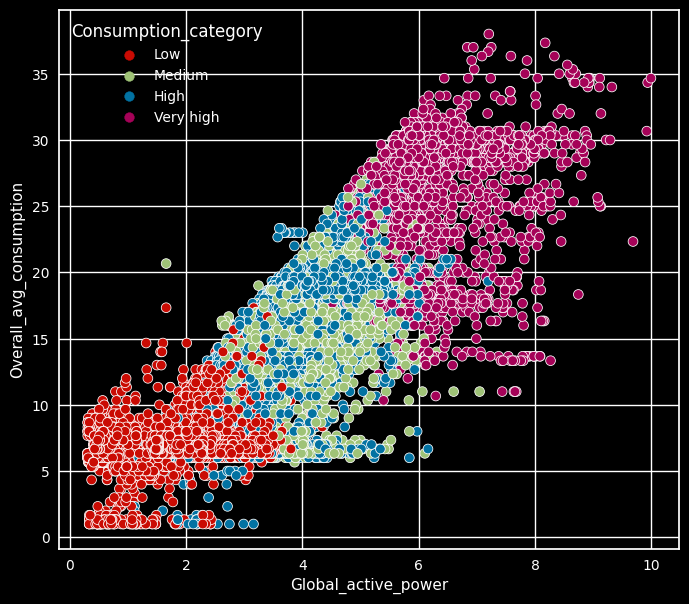

In [118]:
plt.figure(figsize=(8,7))
sns.scatterplot( x= data['Global_active_power'] , y =data['Overall_avg_consumption'], hue =data['Consumption_category'], 
                 palette=['r','g','b','m'])